In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Data Generator

In [26]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, file_paths, img_height=64, img_width=64, batch_size=32, shuffle=True):
        self.file_paths = file_paths
        self.img_height = img_height
        self.img_width = img_width
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_files = self.file_paths[index * self.batch_size:(index + 1) * self.batch_size]
        images = [self.load_and_preprocess_image(file) for file in batch_files]
        return np.array(images), np.array(images)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.file_paths)

    def load_and_preprocess_image(self, path):
        img = tf.keras.preprocessing.image.load_img(path, target_size=(self.img_height, self.img_width))
        img = tf.keras.preprocessing.image.img_to_array(img)
        return img / 255.0 

## Get all the file paths

In [27]:
data_dir = './cartoonset100k_jpg'
img_height, img_width = (64, 64)

file_paths = []
for root, _, files in os.walk(data_dir):
    for file in files:
        if file.lower().endswith(('png', 'jpg', 'jpeg')):
            file_paths.append(os.path.join(root, file))

batch_size = 32
train_generator = DataGenerator(file_paths, img_height=img_height, img_width=img_width, batch_size=batch_size)

## Some examples of the dataset

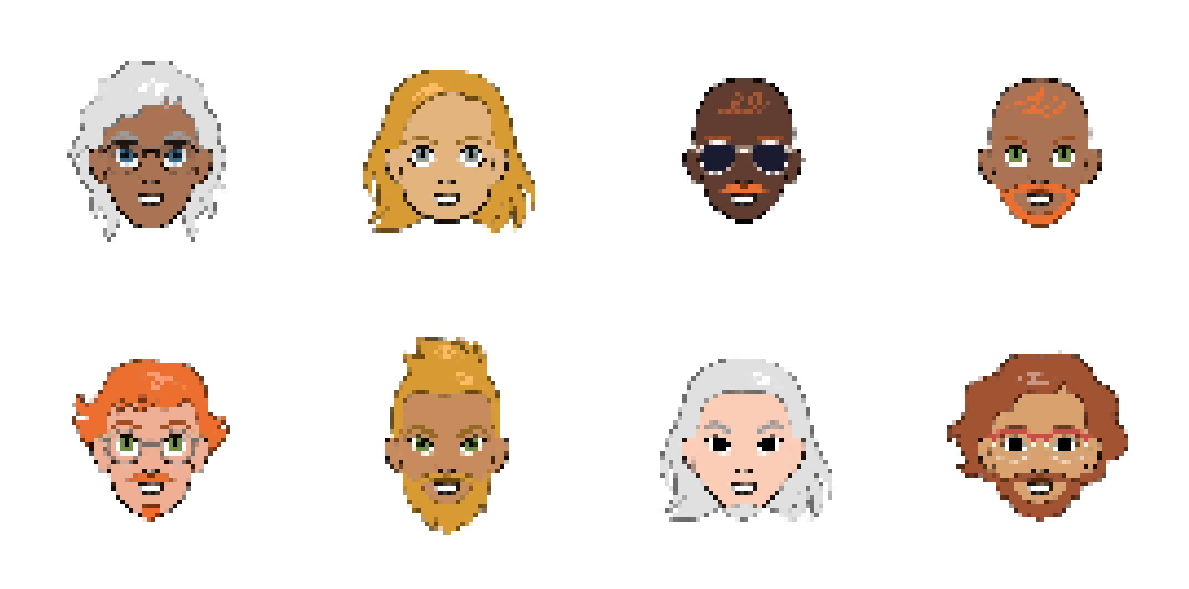

In [28]:
def show_random_images(generator, num_images=8):
    random_indices = np.random.randint(0, len(generator), size=num_images)
    plt.figure(figsize=(12, 6))

    for i, idx in enumerate(random_indices):
        batch_images, _ = generator[idx]

        plt.subplot(2, 4, i + 1)
        plt.imshow(batch_images[0])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_random_images(train_generator, num_images=8)

# Model

## Encoder part

In [29]:
latent_dim = 256

# Encoder
encoder_inputs = tf.keras.layers.Input(shape=(img_height, img_width, 3))
x = tf.keras.layers.Conv2D(8, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = tf.keras.layers.Conv2D(16, 3, activation='relu', strides=2, padding='same')(x)
x = tf.keras.layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(x)
x = tf.keras.layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)

## This class is used to do the sampling task

In [30]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Sampling(name="z")([z_mean, z_log_var])

## Decoder part

In [31]:
# Decoder
decoder_inputs = tf.keras.layers.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(1024, activation='relu')(decoder_inputs)
x = tf.keras.layers.Dense(4 * 4 * 64, activation='relu')(x)
x = tf.keras.layers.Reshape((4, 4, 64))(x)

x = tf.keras.layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = tf.keras.layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
x = tf.keras.layers.Conv2DTranspose(16, 3, activation='relu', strides=2, padding='same')(x)
x = tf.keras.layers.Conv2DTranspose(8, 3, activation='relu', strides=2, padding='same')(x)

decoder_outputs = tf.keras.layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)

In [32]:
encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
decoder = models.Model(decoder_inputs, decoder_outputs, name='decoder')

## VAE model

In [39]:
class VAEModel(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAEModel, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs, training=False):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed

    def train_step(self, data):

        data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstructed = self.decoder(z)
            reconstruction_loss = 10*tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(tf.keras.layers.Flatten()(data), tf.keras.layers.Flatten()(reconstructed))))
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss": total_loss, "reconstruction_loss": reconstruction_loss, "kl_loss": kl_loss}

In [40]:
vae = VAEModel(encoder, decoder)
vae.compile(optimizer='adam')

In [41]:
vae.encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 32, 32, 8)            224       ['input_3[0][0]']             
                                                                                                  
 conv2d_5 (Conv2D)           (None, 16, 16, 16)           1168      ['conv2d_4[0][0]']            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 8, 8, 32)             4640      ['conv2d_5[0][0]']            
                                                                                            

In [42]:
vae.decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256)]             0         
                                                                 
 dense_4 (Dense)             (None, 1024)              263168    
                                                                 
 dense_5 (Dense)             (None, 1024)              1049600   
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 64)          0         
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 8, 8, 64)          36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 16, 16, 32)        18464     
 Transpose)                                                

In [43]:
history = vae.fit(train_generator, epochs=15)

Epoch 1/15
3125/3125 [==============================] - 586s 185ms/step - loss: 60.0361 - reconstruction_loss: 57.2698 - kl_loss: 2.7663
Epoch 2/15
3125/3125 [==============================] - 578s 185ms/step - loss: 56.3812 - reconstruction_loss: 52.4531 - kl_loss: 3.9281
Epoch 3/15
3125/3125 [==============================] - 598s 191ms/step - loss: 54.9108 - reconstruction_loss: 50.4468 - kl_loss: 4.4641
Epoch 4/15
3125/3125 [==============================] - 592s 189ms/step - loss: 54.4056 - reconstruction_loss: 49.6974 - kl_loss: 4.7082
Epoch 5/15
3125/3125 [==============================] - 613s 196ms/step - loss: 53.9595 - reconstruction_loss: 49.0965 - kl_loss: 4.8630
Epoch 6/15
3125/3125 [==============================] - 669s 214ms/step - loss: 53.4052 - reconstruction_loss: 48.3631 - kl_loss: 5.0421
Epoch 7/15
3125/3125 [==============================] - 667s 213ms/step - loss: 53.0228 - reconstruction_loss: 47.8634 - kl_loss: 5.1594
Epoch 8/15
3125/3125 [===================

# Results

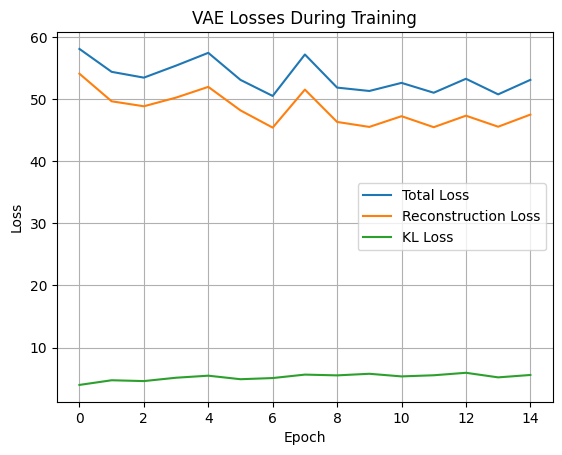

In [46]:
plt.plot(history.history['loss'], label='Total Loss')
plt.plot(history.history['reconstruction_loss'], label='Reconstruction Loss')
plt.plot(history.history['kl_loss'], label='KL Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Losses During Training')
plt.legend()
plt.grid(True)
plt.show()

1/1 [==============================] - 0s 149ms/step


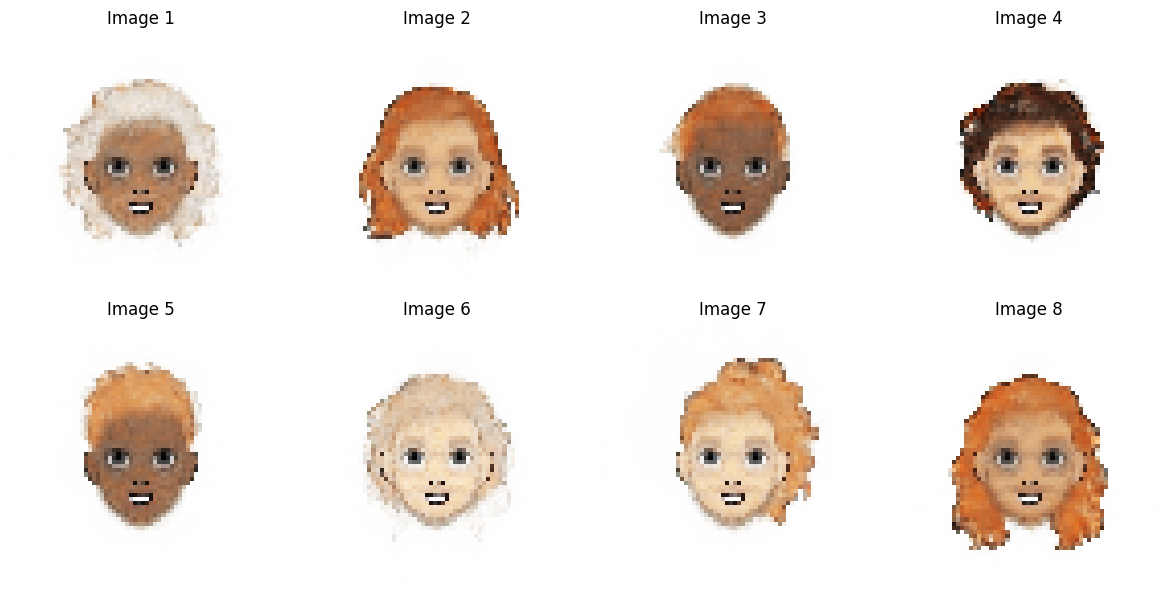

In [60]:
def generate_and_save_images(model, num_images=8):
    random_vectors = np.random.normal(size=(num_images, latent_dim))
    generated_images = model.decoder.predict(random_vectors)
    plt.figure(figsize=(12, 6))
    for i, img in enumerate(generated_images):
        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Image {i+1}')
    plt.tight_layout()
    plt.show()

generate_and_save_images(vae)